In [7]:
from stock.transformer import StdNormalize, AmountVocab
import datetime
import pandas as pd
import numpy as np
import tqdm


df = pd.read_csv("./daily/stock_2024-12-30.csv")
cdf = pd.read_csv("stock_today.csv")
fdf = pd.read_csv("./daily/stock_fund_2024-12-30.csv")
cfdf = pd.read_csv("stock_fund_today.csv")
fdf = pd.concat([fdf,cfdf])
df = pd.concat([df,cdf])
df = df.merge(fdf)
df.dropna(inplace=True)
vnor, snor, mnor= StdNormalize(gap=5.0),StdNormalize(gap=10.0),StdNormalize(gap=25.0)
avocab = AmountVocab(df["amount"].values)
mvocab = AmountVocab(df["main_amount"].values)

def nor_feature(r,p,pg):
    amount, price  = pg["amount"].mean(), pg["close"].mean()
    price_max, price_min = pg["close"].max(), pg["close"].min()
    amount_max, amount_min = pg["amount"].max(), pg["amount"].min()
    close = snor((r.close - p.close)*100/p.close)
    _open = snor((r.open - p.close)*100/p.close)
    high = snor((r.high - p.close)*100/p.close)
    low = snor((r.low - p.close)*100/p.close)
    plow =snor((r.low - price_min)*100/price)
    phigh =snor((r.high - price_max)*100/price)
    pclose =snor((r.close - price)*100/price)
    volume = vnor(np.log2(r.amount/amount))
    vhigh = vnor(np.log2(r.amount/amount_max))
    vlow = vnor(np.log2(r.amount/amount_max))
    amount = avocab(r.amount)/10
    mamount = mvocab(r.main_amount)/10
    mpercent =mnor(r.main_percent)
    # [close,_open,high,low,volume,amount,plow,phigh, pclose,vhigh,vlow]

    return [close,_open,high,low,volume,amount,mamount, mpercent]

def make_data(df, cdate, cnum):
    codes, names, targets, features = [], [], [],[]
    for k,g in tqdm.tqdm(df.sort_values(by="date", ascending=False).groupby("code"),
                         desc=f"processing date[{cdate}]"):
        cur = g[g.date==cdate]
        g = g[g.date<cdate]
        cg, pg = g[:cnum],g[cnum:]
        row = np.zeros((cnum,8),dtype=float)
        if cg.shape[0]==cnum and pg.shape[0]>0:
            pr = cg.iloc[0]
            codes.append(pr["code"])
            names.append(pr["name"])
            if cur.shape[0]>0:
                cr = cur.iloc[0]
                change = snor((cr.close-pr.close)*100/pr.close)
            else:
                change = 0
            targets.append(change)
            for i in range(cg.shape[0]):
                r, p= g.iloc[i],g.iloc[i+1]
                row[i,:] = nor_feature(r,p,pg)
            features.append(row)
        # break
    return pd.DataFrame({"date":cdate, "code":codes,"name":names,"feature":features, "target": targets})

def get_dates(cdt, days=3):
    ctm = datetime.datetime.strptime(cdt,"%Y-%m-%d")
    holidays = set(["2025-01-01"])
    dts = []
    for i in range(1, days+3):
        delta = datetime.timedelta(days=-i)
        ttm = ctm+delta
        if ttm.weekday() <5 and ttm.strftime("%Y-%m-%d") not in holidays:
            dts.append(ttm.strftime("%Y-%m-%d"))
    return dts[:days]
cdate, lst,hdays = "2025-01-03", [], 10
# for dt in get_dates(cdate,5):
#     lst.append(make_data(df,dt, hdays))
# pdf = pd.concat(lst)
cdf = make_data(df, cdate, hdays)
cdf.head()

processing date[2025-01-03]: 100%|██████████| 4411/4411 [00:11<00:00, 400.26it/s]


,date,code,name,feature,target,prediction
0,2025-01-03,sh600000,浦发银行,"[[-0.296084049665712, -0.1623686723973256, -0....",0,1.611983
1,2025-01-03,sh600004,白云机场,"[[-0.358239508700102, -0.16376663254861837, -0...",0,-0.550771
2,2025-01-03,sh600006,东风股份,"[[-0.269576379974326, -0.5519897304236197, 0.0...",0,-5.237739
3,2025-01-03,sh600007,中国国贸,"[[0.06195786864931787, 0.10326311441553078, 0....",0,-3.792608
4,2025-01-03,sh600008,首创环保,"[[-0.388059701492537, -0.20895522388059784, -0...",0,-2.378687


In [2]:
import warnings
warnings.filterwarnings("ignore")
import torch
from stock.base import BaseModel
from stock.models import ConvBERT
from torch import nn
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, random_split, Dataset
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="my_exp_name")


class StockDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return (torch.tensor(row["feature"], dtype=torch.float32),
                torch.tensor([row["target"]],dtype=torch.float32))


class DailyGRU(BaseModel):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(8, 64,num_layers=2, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(2*64, 1)
    def forward(self, x):
        bs,length  = x.shape[0], x.shape[1]
        x = x.view((bs,length,-1))
        output, hn= self.rnn(x)
        y = hn.view((bs,-1))
        ouputs = self.linear(torch.relu(y))
        return torch.tanh(ouputs)

class TranConv(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = ConvBERT(32,8,0.2,hdays)

    def forward(self, x):
        bs,length = x.shape[0], x.shape[1]
        x = x.view((bs,length,-1))
        x = self.model(x)
        ouputs = torch.tanh(x)
        return ouputs


model = TranConv()
valid_len = int(pdf.shape[0]*0.1)
train_dataset, valid_dataset = random_split(StockDataset(pdf), [len(pdf)-valid_len,valid_len])
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader = DataLoader(StockDataset(cdf),batch_size=32,shuffle=False)
callbacks=[EarlyStopping(monitor="val_loss", mode="min",patience=3)]
trainer = L.Trainer(limit_train_batches=100, max_epochs=10, callbacks=callbacks, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.test(model=model, dataloaders = test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | ConvBERT | 51.7 K | train
-------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.11178842931985855    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11178842931985855}]

In [8]:
predictions = trainer.predict(model, test_loader)
pdf = cdf.copy()
pdf["target"] = pdf["target"]*10
pdf["prediction"] = torch.concat(predictions)*10
pdf.sort_values(by="prediction",ascending=False)[:200]

Predicting: |          | 0/? [00:00<?, ?it/s]

,date,code,name,feature,target,prediction
2102,2025-01-03,sz001299,美能能源,"[[-0.06462035541195482, -0.01615508885298978, ...",0,7.654004
4214,2025-01-03,sz301263,泰恩康,"[[-0.3004572175048993, -0.21554539516655785, 0...",0,7.272449
1588,2025-01-03,sh605177,东亚药业,"[[-0.24390243902439046, -0.07113821138211411, ...",0,7.119693
4213,2025-01-03,sz301262,海看股份,"[[-0.7371671169432651, -0.3666538016209955, -0...",0,6.715772
1142,2025-01-03,sh603223,恒通股份,"[[-0.038461538461539345, -0.028846153846154937...",0,6.681245
...,...,...,...,...,...,...
1461,2025-01-03,sh603868,飞科电器,"[[-0.3876852907639687, -0.5838084378563289, -0...",0,3.443802
769,2025-01-03,sh601086,国芳集团,"[[0.5217391304347823, 0.0, 0.9565217391304346,...",0,3.441817
389,2025-01-03,sh600543,莫高股份,"[[-0.10638297872340388, -0.21276595744680962, ...",0,3.438082
1493,2025-01-03,sh603919,金徽酒,"[[-0.34395548811330284, -0.17703591299949312, ...",0,3.434642


MSE is: 11.13
The Pearson Correlation Coefficient is:nan


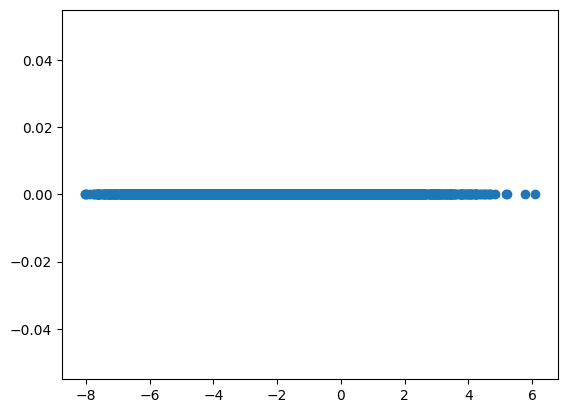

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

smse = mean_squared_error(pdf["prediction"], pdf["target"])
print(f"MSE is: {smse:.2f}")
pr = pearsonr(pdf["prediction"], pdf["target"])[0]
print(f"The Pearson Correlation Coefficient is:{pr:.2f}")
plt.scatter(pdf["prediction"], pdf["target"])
plt.show()

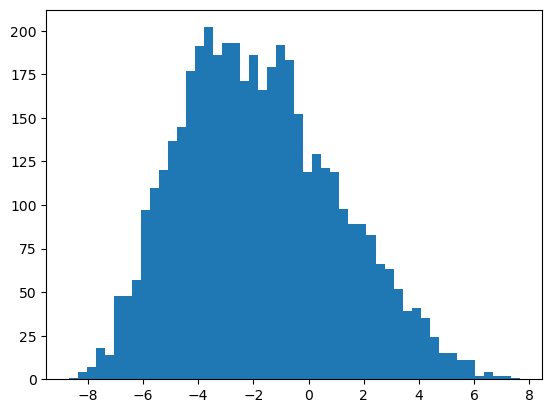

In [5]:
import matplotlib.pyplot as plt
plt.hist(pdf["prediction"], bins=50)
plt.show()